In [2]:
from shakermaker.crustmodel import CrustModel
from shakermaker.ffspsource import FFSPSource

# Model crustal
crustal = CrustModel(3)
# thickness, vp, vs, rho, Qa, Qb
crustal.add_layer(15.5, 5.5, 3.14, 2.5, 1000.0, 1000.0)
crustal.add_layer(31.5, 7.0, 4.0, 2.67, 1000.0, 1000.0)
crustal.add_layer(0.0, 8.0, 4.57, 2.8, 1000.0, 1000.0)

# Create FFSP source with all parameters from your .inp
source = FFSPSource(
    id_sf_type=8,  freq_min=0.01,  freq_max=24.0,
    fault_length=30.0,   fault_width=16.0,
    x_hypc=15.0,  y_hypc=8.0,  depth_hypc=8.0,
    xref_hypc=0.0,  yref_hypc=0.0,
    magnitude=6.5,  fc_main_1=0.09,  fc_main_2=3.0,
    rv_avg=3.0,
    ratio_rise=0.3,
    strike=358.0,  dip=40.0,  rake=113.0,
    pdip_max=15.0,   prake_max=30.0,
    nsubx=256,   nsuby=128,
    # nsubx=32,   nsuby=32,
    nb_taper_trbl=[5, 5, 5, 5],
    seeds=[52, 448, 4446],
    id_ran1=1,  id_ran2=10,
    angle_north_to_x=0.0,
    is_moment=3,
    crust_model=crustal,
    work_dir='./ffsp_output',
    cleanup=False,  
    verbose=True,
)

In [ ]:
# Run FFSP
subfaults = source.run()

--- Working directory: ./ffsp_output
Running FFSP...
 The corner freqs are:   3.73680517E-02   1.00000060    
 ratio=    1.31781018    
 Finishing the setup of global variable
 Magnitude =    6.49999952    
 expected double corner frequency =    3.73680517E-02   1.00000060    
 expected Td_95=    6.64759398    
 expected average rise time =  0.839999497    
 ntime =       131072  lnpt =           17
 nphf =        65536
 nbb =            1  nee =           12
 io_dva =            3
 cross rise, slip-amp  0.741196692      0.750000000      0.750000000    
 correlation between slip and rise time =   0.741196692    
 correlation between stress drop and rise time =   0.741193712    
 creating k^-1 peak time distribution with mean of   0.167999908      0.995000005    
 correct =   0.168226287    
 correlation between pktm and slip=    5.44123240E-02
 correlation between pktm and rise time=    2.31130607E-02
 maximum rupture time =   8.76516342    
 maximum and minimum    1.86415040       3.0

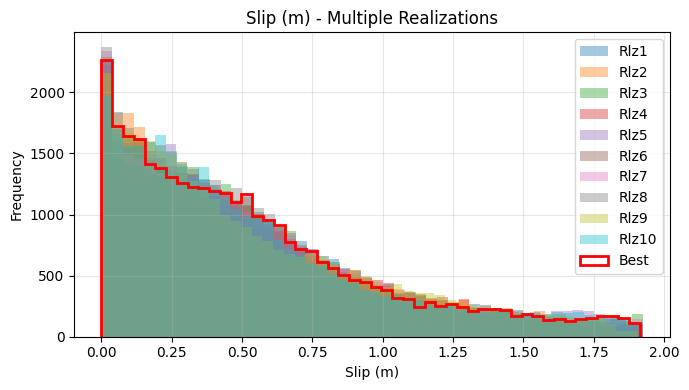

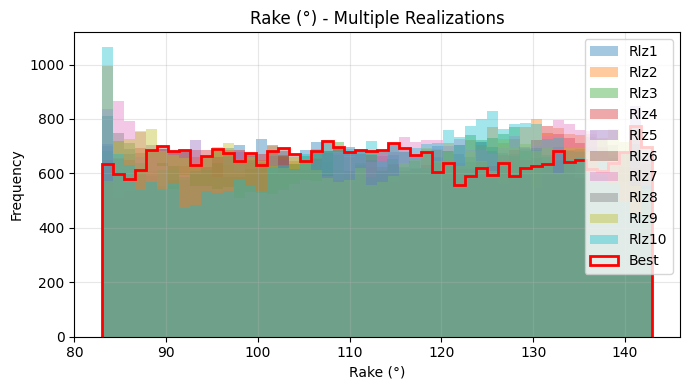

In [4]:
# Slip
source.plot_histogram(field='slip', bins=50, figsize=(7, 4))
# Rake
source.plot_histogram(field='rake', bins=50, figsize=(7, 4))

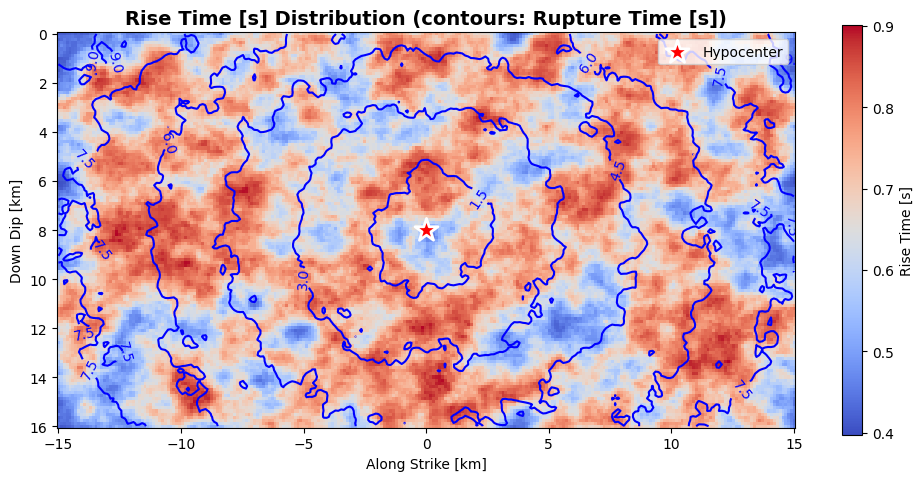

In [5]:
# Plot slip distribution of active realization
source.set_active_realization(7)  
source.plot_spacial_distribution(figsize=(10, 8), cmap='coolwarm')

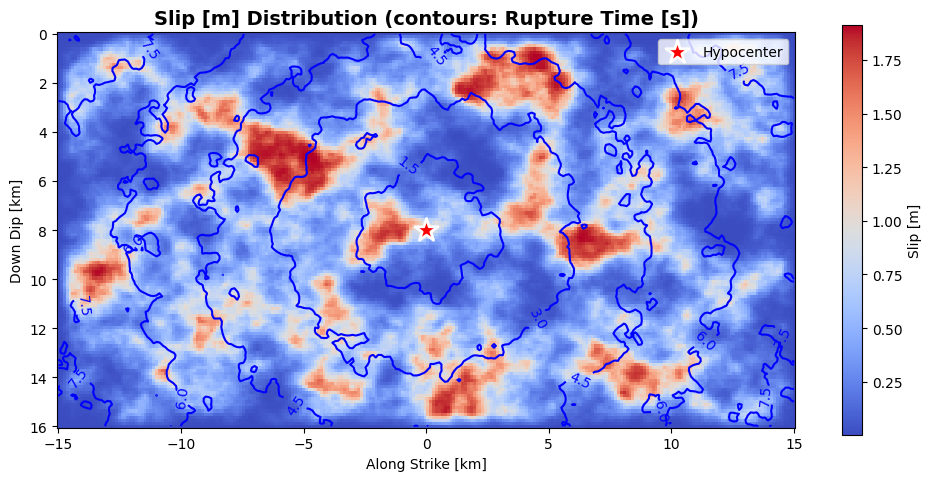

In [6]:
# Plot slip distribution of active realization
source.subfaults = source.best_realization
source.plot_spacial_distribution(field='slip', figsize=(10, 8), cmap='coolwarm', 
                                 show_contours=True, contour_field='rupture_time', show_hypocenter=True)

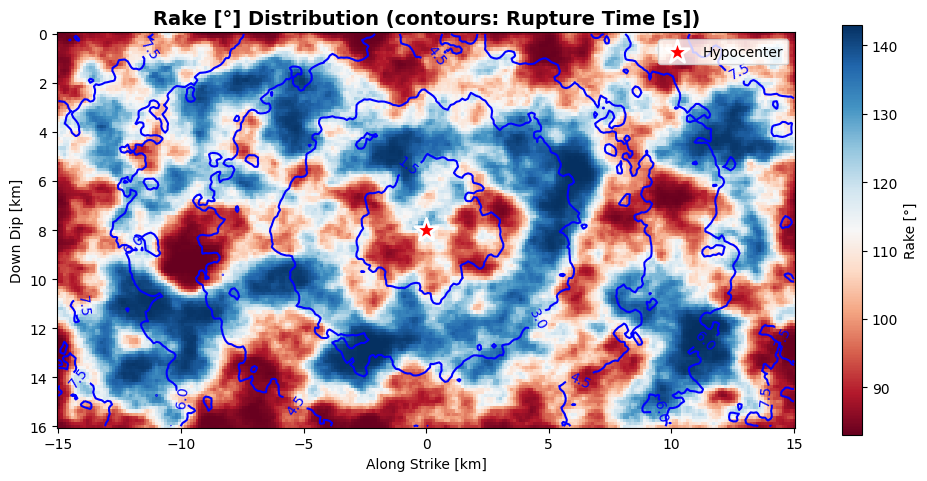

In [7]:
# Plot slip distribution of active realization
source.subfaults = source.best_realization
source.plot_spacial_distribution(field='rake', figsize=(10, 8), cmap='RdBu', 
                                 show_contours=True, contour_field='rupture_time', show_hypocenter=True)

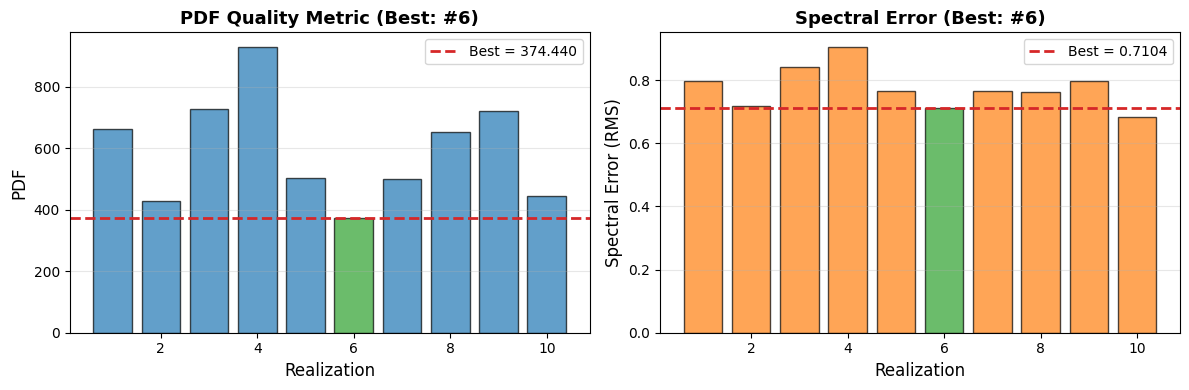

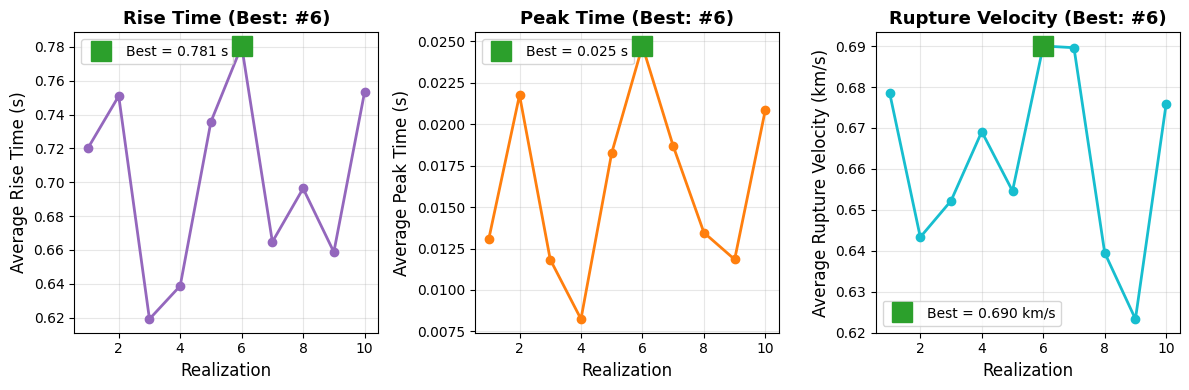

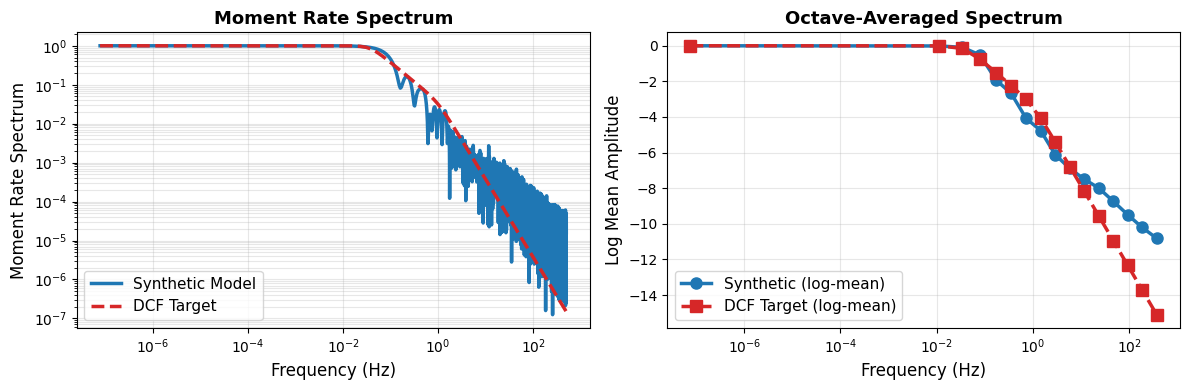

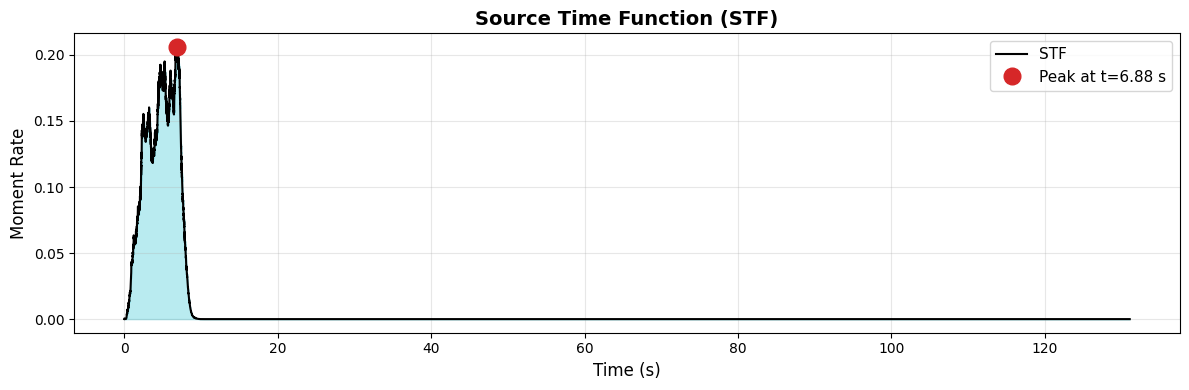

In [8]:
# Plot PDF and Spectral Error side by side
source.plot_quality_metrics(figsize=(12, 4))
# Plot Rise Time, Peak Time, and Rupture Velocity
source.plot_temporal_metrics(figsize=(12, 4))
# Plot Moment Rate Spectrum and Octave-Averaged Spectrum side by side
source.plot_spectral_comparison(figsize=(12, 4))
# Plot Source Time Function (STF)
source.plot_source_time_function(figsize=(12, 4))

In [9]:
#Configuracion shakermaker
dt = 0.0025         # Paso de tiempo
nfft = 8192*2       # Numero de muestras del registro
dk = 0.2#.02        # (discretizacion en espacio de longitud de onda) ajustar usando la teoria 
tb = 0              # Cuanto tiempo "adelantar" la ventana de simulacion... no adelantar
tmin = 0.           # tiempo en que comienzan los resultados finales
tmax = 150.         # tiempo en que terminan los resultados finales

Extracting subfaults...
Created 2 point sources (slip >= 1.9217)
Total subfaults: 32768
Filtered out: 32766
Created 2 point sources


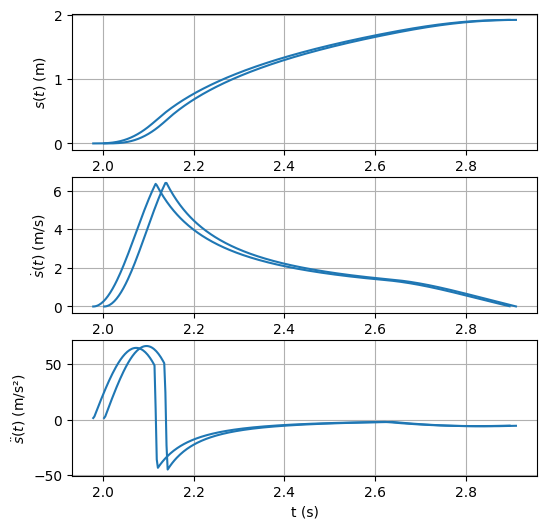

Building ShakerMaker model...
Running simulation...



🎉 ¡LARGA VIDA AL LADRUNO! 🎉 ShakerMaker Run begin. dt=0.0025 nfft=16384 dk=0.2 tb=0 tmin=0.0 tmax=150.0
-------------------------------------------------------------------------------------------------------
Hybrid Parallelization:
   MPI processes    : 1
   OpenMP threads   : not set
   Parallelization strategy:
      - MPI level : distributes source-receiver pairs across 1 processes
      - OpenMP    : parallelizes frequencies and FFTs within each pair
-------------------------------------------------------------------------------------------------------
0 of 2 done t[0]=3.6227 t[-1]=85.5402 (tmin=0.0000 tmax=150.0000)
1 of 2 done t[0]=3.6554 t[-1]=85.5729 (tmin=0.0000 tmax=150.0000)



ShakerMaker Run done. Total time: 31.336678046999964 s
------------------------------------------------
Simulation complete!


In [10]:
from shakermaker import shakermaker
from shakermaker.pointsource import PointSource 
from shakermaker.faultsource import FaultSource
from shakermaker.stf_extensions import Discrete
from shakermaker.station import Station
from shakermaker.stationlist import StationList
import numpy as np
from scipy.integrate import cumulative_trapezoid


def srf2(Tp, Te, Tr, dt):
    a = 1.
    b = 100.
    t = np.arange(0, Tr, dt)
    Nt = len(t)
    svf = 0*t
    i1 = t < Tp
    svf[i1] = t[i1]/Tp*np.sqrt(a + b/Tp**2)*np.sin(np.pi*t[i1]/(2*Tp))
    i2 = np.logical_and(t >= Tp, t < Te)
    svf[i2] = np.sqrt(a + b/t[i2]**2)
    i3 = t >= Te
    svf[i3] = np.sqrt(a + b/t[i3]**2)*np.sin(5/3*np.pi*(Tr-t[i3])/Tr)
    A = np.trapz(svf, dx=dt)
    svf /= A
    return Nt, svf

print("Extracting subfaults...")
# subfaults = source.best_realization
source.set_active_realization(0)  
subfaults = source.get_subfaults()
x = subfaults['x']
y = subfaults['y']
z = subfaults['z']
slip = subfaults['slip']
strike = subfaults['strike']
dip = subfaults['dip']
rake = subfaults['rake']
rupture_time = subfaults['rupture_time']
rise_time = subfaults['rise_time']


pt_rt = 0.15

dx = source.params['fault_length'] / (source.params['nsubx']-1)
dy = source.params['fault_width'] / (source.params['nsuby']-1)
A = (dx * 1000) * (dy * 1000)

nsubfaults = len(slip)
ρ = 2500.0
Vs = 3140.0
μ = ρ * Vs**2

slip_max = slip.mean()
M0 = μ * A * slip_max * nsubfaults
conversion_N_m_a_dyne_cm = 1e7
Mw = 2/3 * np.log10(M0*conversion_N_m_a_dyne_cm) - 10.7

# print(f"Total subfaults: {nsubfaults}")
# print(f"Subfault area: {A:.2f} m²")
# print(f"Slip promedio: {slip_max:.2f} m")
# print(f"M0: {M0:.2e} N·m")
# print(f"Mw: {Mw:.2f}")

fault_list = []
stf_data = []
stf_data_all = []
#El minimo slip
MINSLIP = 1.9217


for i in range(nsubfaults):
    xsrc = x[i] / 1e3
    ysrc = y[i] / 1e3
    zsrc = z[i] / 1e3
    ϕ = strike[i]
    θ = dip[i]
    λ = rake[i]
    t0 = rupture_time[i]
    Tr = rise_time[i]
    Tp = pt_rt * Tr
    Te = 0.7 * Tr
    [Nt, slip_velocity] = srf2(Tp, Te, Tr, dt)
    t = np.arange(Nt) * dt
    slip_rate = slip_velocity * slip[i]
    slip_rate_integrate = cumulative_trapezoid(slip_rate,t, initial=0.)
    slip_rate_derivate = np.gradient(slip_rate, t)

    stf_data_all.append({'t': t + t0, 'slip_rate': slip_rate, 'slip': slip[i], 'slip_rate_integrate': slip_rate_integrate , 'slip_rate_derivate': slip_rate_derivate})
        
    if slip[i] < MINSLIP:
        continue
    
    stf = Discrete(slip_rate, t)
    stf_data.append({'t': t + t0, 'slip_rate': slip_rate, 'slip_rate_integrate': slip_rate_integrate, 'slip_rate_derivate': slip_rate_derivate})
    point_source = PointSource([xsrc, ysrc, zsrc], [ϕ, θ, λ], tt=t0, stf=stf)
    fault_list.append(point_source)


print(f"Created {len(fault_list)} point sources (slip >= {MINSLIP})")
print(f"Total subfaults: {nsubfaults}")
print(f"Filtered out: {nsubfaults - len(fault_list)}")
print(f"Created {len(fault_list)} point sources")




import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))

plt.subplot(3, 1, 1)
for data in stf_data:
    plt.plot(data['t'], data['slip_rate_integrate'], linewidth=1.5, color='tab:blue')
plt.ylabel("$s(t)$ (m)")
plt.grid(True)

plt.subplot(3, 1, 2)
for data in stf_data:
    plt.plot(data['t'], data['slip_rate'], linewidth=1.5, color='tab:blue')
plt.ylabel("$\\dot{s}(t)$ (m/s)")
plt.grid(True)

plt.subplot(3, 1, 3)
for data in stf_data:
    plt.plot(data['t'], data['slip_rate_derivate'], linewidth=1.5, color='tab:blue')
plt.ylabel("$\\ddot{s}(t)$ (m/s²)")
plt.xlabel("t (s)")
plt.grid(True)

plt.show()


# ---------------------------
fault = FaultSource(fault_list, metadata={"name": f"FFSP_Mw{Mw:.2f}"})
station = Station([6.0, 8.0, 0.0], metadata={"name": "Station_01"})
stations = StationList([station], {})

print("Building ShakerMaker model...")
model = shakermaker.ShakerMaker(crustal, fault, stations)

print("Running simulation...")
model.run(
    dt=dt,
    nfft=nfft,      # N timesteps
    dk=dk,         # wavenumber discretization
    tb=tb,          # Initial zero-padding
    tmin = tmin,    
    tmax = tmax,
    smth=1,
    sigma=2,
    verbose=False,
    showProgress=True,
)
station.save("sta01.npz")
print("Simulation complete!")


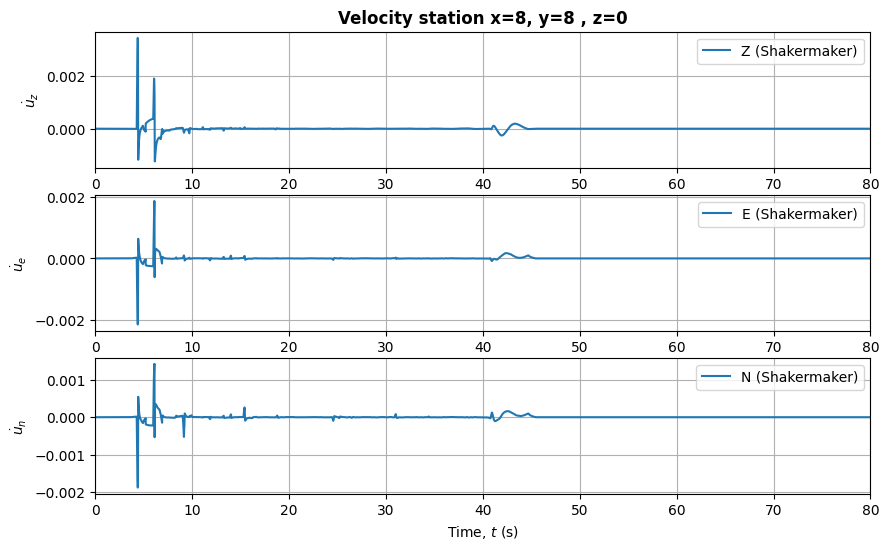

In [11]:
z_v1,e_v1,n_v1,t1 = station.get_response()

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.title("Velocity station x=8, y=8 , z=0", fontweight='bold')
plt.plot(t1, z_v1, label="Z (Shakermaker)")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{u}_z$")
plt.xlim([0,80])
plt.grid()
plt.legend()

plt.subplot(3,1,2)
plt.plot(t1, e_v1, label="E (Shakermaker)")
plt.ylabel(r"$\dot{u}_e$")
plt.xlim([0,80])
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.plot(t1, n_v1, label="N (Shakermaker)")
plt.ylabel(r"$\dot{u}_n$")
plt.xlabel(r"Time, $t$ (s)")
plt.xlim([0,80])
plt.grid()
plt.legend()

plt.show()